# Sample code for CNN-AE/SINDy modeling
## Authors: Kai Fukami (UCLA) and Takaaki Murata (Keio)
### ・We provide no guarantees for this code. Use as-is and for academic research use only; no commercial use allowed without permission. For citations, please use the reference below:
### ・Ref: Kai Fukami, Takaaki Murata, Kai Zhang, and Koji Fukagata, "Sparse identification of nonlinear dynamics with low-dimensionalized flow representations," J. Fluid Mech, 2021.

### ・The code is written for educational clarity and not for speed.
### ・Since this is a sample notebook, we also do not provide a data set (cylinder wake at $Re_D=100$) and CNN-AE. For the data set and CNN-AE, please refer to our previous papars with their sample codes as follows:
#### 1. T. Murata, K. Fukami, and K. Fukagata, "Nonlinear mode decomposition with convolutional neural networks for fluid dynamics," J. Fluid Mech. 882, A13 (2020).
#### 2. K. Hasegawa, K. Fukami, T. Murata, and K. Fukagata, "CNN-LSTM based reduced order modeling of two-dimensional unsteady flows around a circular cylinder at different Reynolds numbers," Fluid Dyn. Res. 52, 065501 (2020).

### -- Version 1: Aug 1, 2021

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Input#, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Times New Roman']})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rc('font', family='Times New Roman')
plt.rcParams['text.latex.preamble']='\\usepackage{amsmath}'

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

from keras.models import load_model
import pickle
import copy, h5py
from tqdm import tqdm_notebook as tqdm
from copy import deepcopy as cp

from sklearn import linear_model

import tensorflow as tf

from keras.backend import tensorflow_backend

config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
tensorflow_backend.set_session(session)

from notify_run import Notify
notify = Notify()

/home/fukami/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/fukami/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
cx1=np.linspace(8.5,9.5,100)
cy1=np.sqrt(0.25-(cx1-9)**2)
cx2=np.linspace(9.5,8.5,100)
cy2=-np.sqrt(0.25-(cx1-9)**2)
circx=np.concatenate([cx1,cx2])
circy=np.concatenate([cy1,cy2])

# Load field

In [4]:
# dt1->2.5e-3, 10->2.5e-2
dt1xx=1
dt10xx=0

start0=0
end0=5
dirname="dt100/"
if(dt1xx):
    dirname="dt1/"
if(dt10xx):
    dirname="dt10/"

Xrall=[]
for i in tqdm(range(start0,end0)):
#     print(i)
    fnstr="/home/web/databank/periodic_cylinder_uv_"+dirname+"data" + '{0:01d}'.format(i)+".pickle"
    # Pickle load
    with open(fnstr, 'rb') as f:
        obj = pickle.load(f)
    if i==start0:
        Xrall=obj
    else:
        Xrall=np.concatenate([Xrall,obj],axis=0)

print(Xrall.shape)

(10000, 384, 192, 2)


## Number of snapshots

In [235]:
num_of_ts=1000
num_of_ts=10000
# num_of_ts=2331
Xr=cp(Xrall[:num_of_ts,:,:,:])
print(Xr.shape)
print(num_of_ts/(1/0.1716/0.025))
x_num=401; y_num=201;

(10000, 384, 192, 2)
42.9


In [236]:
# prepare coordinate
xcor=pd.read_csv("../contfield/Xcor", header=None, delim_whitespace=True)
ycor=pd.read_csv("../contfield/Ycor", header=None, delim_whitespace=True)
xcor=xcor.values; ycor=ycor.values; 
xc=xcor[0:x_num,0]; x12c=xcor[0:x_num,1];
yc=ycor[0:y_num,0]; y12c=ycor[0:y_num,1]; 

# print(xc)
xc=np.delete(xc,0)
yc=np.delete(yc,0)

for i in range(int((len(yc)-192)*0.5)):
    yc=np.delete(yc,0,0)
    yc=np.delete(yc,len(yc)-1,0)

for i in range(int((len(xc)-384)*0.5)):
    xc=np.delete(xc,0,0)
    xc=np.delete(xc,len(xc)-1,0)    

ddx=0.5*(xc[2]-xc[1])
xca=np.linspace(xc[0]-ddx,xc[len(xc)-1]+ddx,len(xc)+1)
ddy=0.5*(yc[2]-yc[1])
yca=np.linspace(yc[0]-ddx,yc[len(yc)-1]+ddy,len(yc)+1)


In [237]:
mode0=pd.read_csv("../POD/field_data/mode0.csv", header=None, delim_whitespace=None)
mode0=mode0.values

x_num0=384; y_num0=192;
Uf0=mode0[0:x_num0*y_num0]
Vf0=mode0[x_num0*y_num0:x_num0*y_num0*2]

Uf0=np.reshape(Uf0,[x_num0,y_num0])
Vf0=np.reshape(Vf0,[x_num0,y_num0])


In [238]:
# Extract avg
Xf=np.empty_like(Xr)
Xf[:,:,:,0]=Xr[:,:,:,0]-Uf0
Xf[:,:,:,1]=Xr[:,:,:,1]-Vf0

# CNN
## Prepare network

In [239]:
model_name='./resultss0326_CCNNFC/cnn1.hdf5'

autoencoder = load_model(model_name)
x_num=401; y_num=201;

In [240]:
# enc.
enc_input = Input(shape=(384,192,2))

deco = autoencoder.layers[1](enc_input)
deco = autoencoder.layers[2](deco)
deco = autoencoder.layers[3](deco)
deco = autoencoder.layers[4](deco)
deco = autoencoder.layers[5](deco)
deco = autoencoder.layers[6](deco)
deco = autoencoder.layers[7](deco)
deco = autoencoder.layers[8](deco)
deco = autoencoder.layers[9](deco)
deco = autoencoder.layers[10](deco)
deco = autoencoder.layers[11](deco)
deco = autoencoder.layers[12](deco)
deco = autoencoder.layers[13](deco)
enc = autoencoder.layers[14](deco)

print(enc.shape)
# create the decoder model
encoder = Model(enc_input, enc)

# encoder.summary()

# decoder.save('fukank.hdf5')

(?, 2)


In [241]:
# dec
encoded_input = Input(shape=(2,))

deco = autoencoder.layers[15](encoded_input)
deco = autoencoder.layers[16](deco)
deco = autoencoder.layers[17](deco)
deco = autoencoder.layers[18](deco)
deco = autoencoder.layers[19](deco)
deco = autoencoder.layers[20](deco)
deco = autoencoder.layers[21](deco)
deco = autoencoder.layers[22](deco)
deco = autoencoder.layers[23](deco)
deco = autoencoder.layers[24](deco)
deco = autoencoder.layers[25](deco)
deco = autoencoder.layers[26](deco)
deco = autoencoder.layers[27](deco)
deco = autoencoder.layers[28](deco)
# create the decoder model
decoder = Model(encoded_input, deco)

# decoder.summary()

# decoder.save('fukank.hdf5')

## Inp->enc

In [242]:
X=encoder.predict(Xf,verbose=1)
Xor=cp(X)

10000/10000 [==============================] - 22s 2ms/step


In [243]:
X=Xor

print(X.shape)

(10000, 2)


# Prepare SINDy

In [244]:
# prepare time-axis
dtsnap=2.5e-3*100
if dt1xx:
    dtsnap=dtsnap*0.01
if dt10xx:
    dtsnap=dtsnap*0.1
# n_ts=len(X[0,:])
n_ts=len(X[:,0])
taxx=np.arange(0,dtsnap*n_ts,dtsnap)

tax=np.arange(dtsnap,dtsnap*(n_ts-2)+1e-5,dtsnap)

In [245]:
# Xd=taxx
# Yd=X[0,:]
Xd=X[:,0]
Yd=X[:,1]
Xdinit=Xd[0]; Ydinit=Yd[0]

rXd=cp(Xd)
rYd=cp(Yd)
# dX, dY
data=np.zeros([len(rXd)-2,2])
data[:,0]=rXd[1:len(rXd)-1]
data[:,1]=rYd[1:len(rYd)-1]
print(data.shape)
ddata=np.empty_like(data)
for i in range(len(Xd)-2):
    ddata[i,0]=(rXd[i+2]-rXd[i])/(2*dtsnap)
    ddata[i,1]=(rYd[i+2]-rYd[i])/(2*dtsnap)
# 2nd-order
print(ddata)

(9998, 2)
[[-0.78204918  0.1923182 ]
 [-0.75022924  0.37786353]
 [-0.68044734  0.55718076]
 ...
 [ 0.37230361  0.66373819]
 [ 0.57479089  0.48498821]
 [ 0.7198981   0.29167295]]


## Make Library matrix (RHS)

In [246]:
n_order=5#+10

# n_order=2

usesin=False

usfl=0
if usesin:
    usfl=4

ii=0
for i in range(n_order+1):
    for j in range(i+1):
        ii=ii+1
RHS=np.zeros([len(data),ii+usfl])+1
print(RHS.shape)
ii=0
for i in range(n_order+1):
    for j in range(i+1):
#         print(ii)
        RHS[:,ii]=data[:,0]**(i-j)*data[:,1]**j
        ii=ii+1
print(RHS[1,:])

if usesin:
    RHS[:,ii+0]=np.sin(RHS[:,1])
    RHS[:,ii+1]=np.cos(RHS[:,1])
    RHS[:,ii+2]=np.sin(RHS[:,2])
    RHS[:,ii+3]=np.cos(RHS[:,2])

(9998, 21)
[ 1.00000000e+00 -2.32075989e-01 -6.65703535e-01  5.38592648e-02
  1.54493806e-01  4.43161197e-01 -1.24994422e-02 -3.58543030e-02
 -1.02847073e-01 -2.95013975e-01  2.90082040e-03  8.32092283e-03
  2.38683362e-02  6.84656601e-02  1.96391846e-01 -6.73210765e-04
 -1.93108640e-03 -5.53926774e-03 -1.58892358e-02 -4.55778320e-02
 -1.30738746e-01]


## Plot

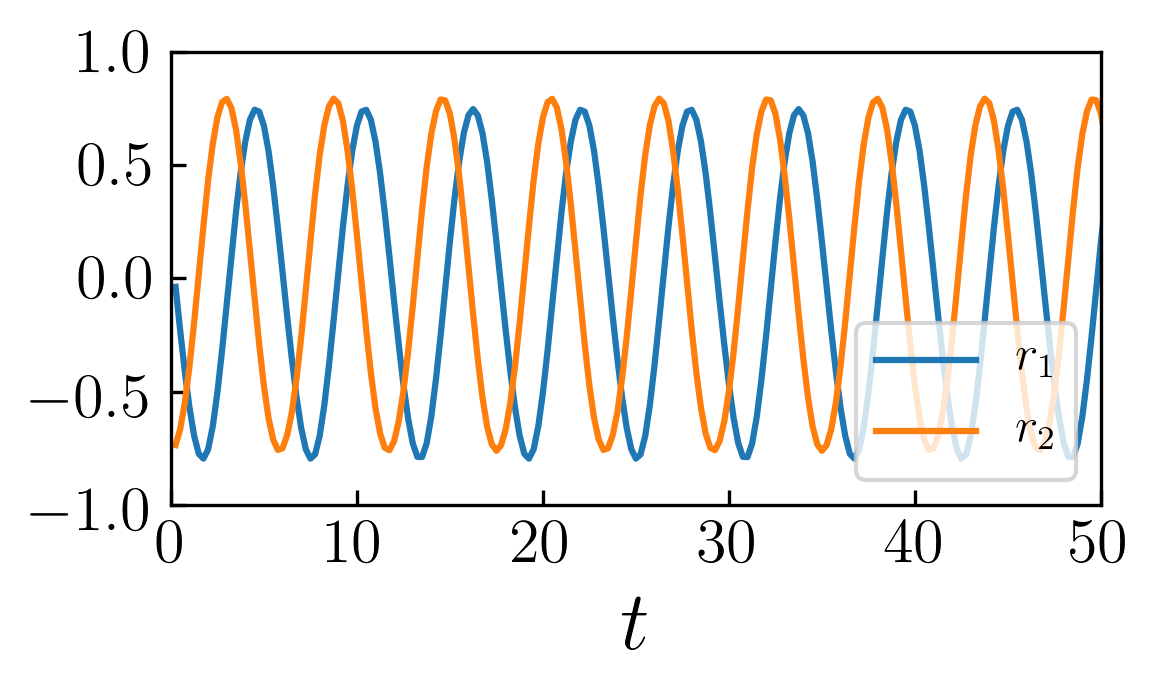

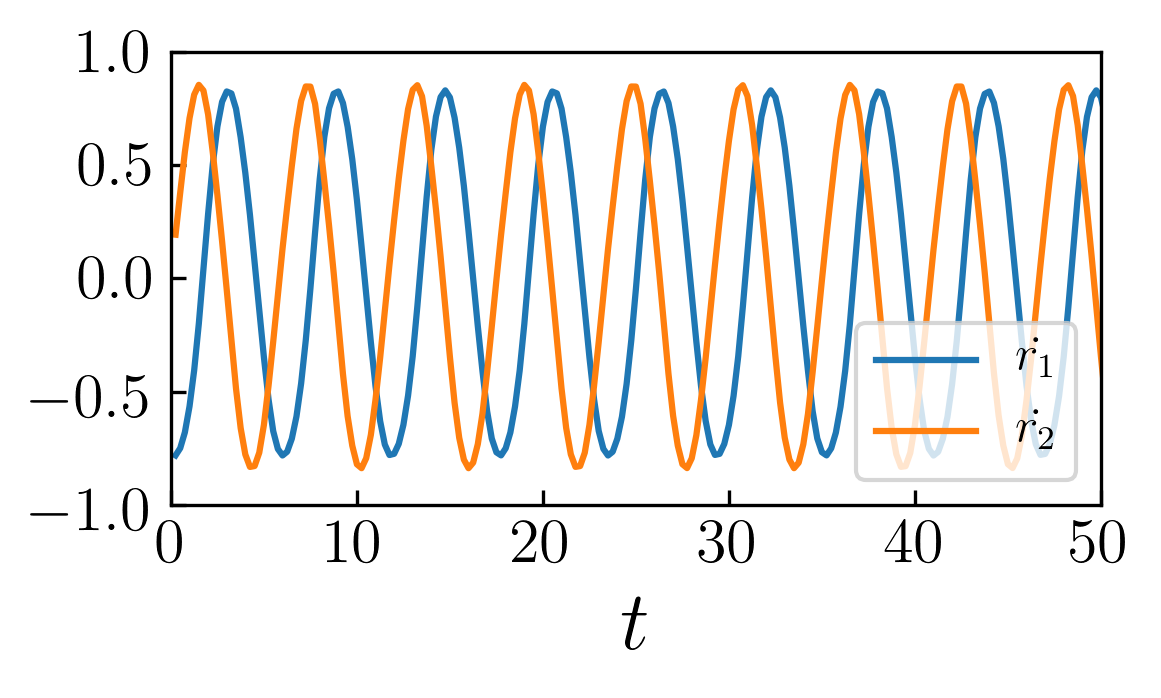

In [247]:
fig=plt.figure(dpi=300,figsize=(4,2))
plt.plot(tax,data[:,0],label=r'$r_1$')
plt.plot(tax,data[:,1],label=r'$r_2$')
plt.xlim([0,50])
# plt.xlim([0,10])
plt.legend(loc='lower right',fontsize=12)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel(r'$t$',fontsize=20)
# plt.ylabel(r'Value',fontsize=20)
plt.ylim([-1,1])
plt.show()

fig=plt.figure(dpi=300,figsize=(4,2))
plt.plot(tax,ddata[:,0],label=r'$\dot{r_1}$')
plt.plot(tax,ddata[:,1],label=r'$\dot{r_2}$')
plt.xlim([0,50])
# plt.xlim([0,10])
plt.legend(loc='lower right',fontsize=12)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$t$',fontsize=20)
# plt.ylabel(r'Value',fontsize=20)
plt.ylim([-1,1])
plt.show()

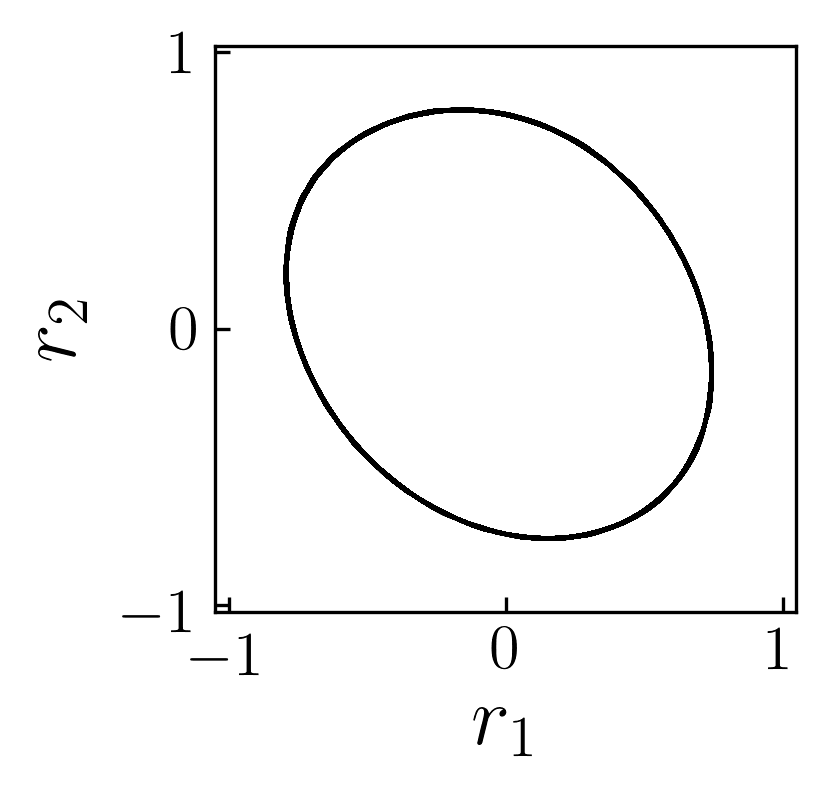

In [248]:
# nlp=2000
plt.figure(dpi=300,figsize=(2.5,2.5))
plt.axis('equal')
plt.plot(data[:,0],data[:,1],'k',lw=0.7,label='Original')
plt.xlabel(r"$r_1$",fontsize=20)
plt.ylabel(r"$r_2$",fontsize=20)
plt.xticks([-1,0,1],fontsize=15)
plt.yticks([-1,0,1],fontsize=15)
plt.xlim([-1.05,1.05])
plt.ylim([-1.05,1.05])
# plt.legend()
plt.show()

# Loop

In [249]:
LHS=copy.deepcopy(ddata)

print(RHS.shape)
print(LHS.shape)

(9998, 21)
(9998, 2)


In [250]:
# PARAMS

alr=np.array([\
              1e-9,1.2e-9,2e-9,3e-9,5e-9,7e-9,\
              1e-8,1.2e-8,2e-8,3e-8,5e-8,7e-8,\
              1e-7,1.2e-7,2e-7,3e-7,5e-7,7e-7,\
              1e-6,1.2e-6,2e-6,3e-6,5e-6,7e-6,\
              1e-5,1.2e-5,2e-5,3e-5,5e-5,7e-5,\
              1e-4,1.2e-4,2e-4,3e-4,5e-4,7e-4,\
              1e-3,1.2e-3,2e-3,3e-3,5e-3,7e-3,\
              1e-2,1.2e-2,2e-2,3e-2,5e-2,7e-2,\
              1e-1,1.2e-1,2e-1,3e-1,5e-1,7e-1\
             ])

# alr=np.array([1.2e-5])

kaijo=1+2


l_max_iter=1000 # Default
l_tol=0.0001 # Default
# l_tol=0.00001

# l_max_iter=100
# l_tol=1e-3

##################
stat=tax[0]
endt=1000
taxint=np.arange(dtsnap,endt,dtsnap)
dtff=cp(dtsnap)

##################

from sklearn.linear_model import Lasso
rms1=np.zeros_like(alr)
mean1=np.zeros_like(alr)
nxcmp=np.zeros_like(alr)
nycmp=np.zeros_like(alr)
aic=np.zeros_like(alr)
starray=np.zeros_like(alr)
from scipy.integrate import solve_ivp

LHS0=LHS[:,0]
LHS1=LHS[:,1]

RHS0=copy.deepcopy(RHS)
RHS1=copy.deepcopy(RHS)

lrhs=len(RHS[0,:])
llhs=len(LHS[0,:])

xi1=np.zeros([lrhs,llhs])

from copy import deepcopy as cp
def alasso(XXX,yyy,alr):
    from sklearn.linear_model import Lasso
    # Params
    n_lasso_iterations = 100
    tol=1e-10
    abs1 = lambda w: (np.abs(w)**kaijo + 1e-30)

    n_samples, n_features = XXX.shape
    weights = np.ones(n_features) # Prepare
    for k in range(n_lasso_iterations):
        prevw=cp(weights)
        XXX_w = XXX / weights[np.newaxis, :] # STEP 1
        clf = Lasso(alpha=alr,fit_intercept=False,max_iter=l_max_iter,tol=l_tol) # STEP 2-1
        clf.fit(XXX_w, yyy) # STEP 2-2
        coef_ = clf.coef_ / weights # STEP 2-3
        weights = 1/abs1(coef_) # STEP 3
        if(np.mean((weights-prevw)**2)<tol):
            break
    return coef_

In [251]:
# Calc True value of RMS and Mean
intx1=data[:,0]
intx2=data[:,1]

meanx1=np.mean(intx1)
meanx2=np.mean(intx2)
meant=meanx1+meanx2

msx1=np.sum((intx1-meanx1)**2)
msx2=np.sum((intx2-meanx2)**2)

tempval=len(intx1)
rmsx1=np.sqrt(msx1/tempval)
rmsx2=np.sqrt(msx2/tempval)
rmst=rmsx1+rmsx2

# meansquare=np.sum((t1023[-t1023num:]-meant)**2)
# rmst=np.sqrt(meansquare/t1023num)

print(rmst,meant)

1.0968052314290233 -0.007243077243108142


## Start loop

In [252]:
import timeout_decorator
@timeout_decorator.timeout(300) # Set timeout here because in some cases the integration does not end (may be too fine time step in the computational code for the stability)
def loop(i):
    # Fit
    # 0
    xi1[:,0]=alasso(RHS0,LHS0,alr[i])
    
    # 1
    xi1[:,1]=alasso(RHS1,LHS1,alr[i])
    
    xi=xi1.T
    xi=xi.astype(np.float16)
#     na_float = na_int.astype(numpy.float16)
    
    nxcmp[i]=np.count_nonzero(xi[0,:])
    nycmp[i]=np.count_nonzero(xi[1,:])
    
    def deriv2(t,y): 
        xxx=y[0]
        yyy=y[1]
        ii=0
        for i in range(n_order+1):
            for j in range(i+1):
                ii=ii+1
        rrhs=np.zeros([ii+usfl])+1
        ii=0
        for i in range(n_order+1):
            for j in range(i+1):
        #         print(ii)
                rrhs[ii]=xxx**(i-j)*yyy**j
                ii=ii+1
        if usesin:
            rrhs[ii+0]=np.sin(rrhs[1])
            rrhs[ii+1]=np.cos(rrhs[1])
            rrhs[ii+2]=np.sin(rrhs[2])
            rrhs[ii+3]=np.cos(rrhs[2])

        reconstx=np.dot(rrhs,xi.T)
    #     print(rrhs)
        return ([reconstx[0], reconstx[1]])

    v0=[data[0,0],data[0,1]]
    vodeivp=solve_ivp(deriv2, [stat,endt], v0, method='RK45',t_eval=taxint)#,min_step=dtff)
    vodet=vodeivp.t
    vodey=vodeivp.y
    
    # NEW RMS
    tempval=-100
    intx1=vodey[0,:]
    intx2=vodey[1,:]
    
    meanx1=np.mean(intx1)
    meanx2=np.mean(intx2)
    mean1[i]=meanx1+meanx2
    
    msx1=np.sum((intx1[tempval:]-meanx1)**2)
    msx2=np.sum((intx2[tempval:]-meanx2)**2)
    
    rmsx1=np.sqrt(msx1/tempval*-1)
    rmsx2=np.sqrt(msx2/tempval*-1)
    rms1[i]=rmsx1+rmsx2
    
    stable_len=int((endt*0.8)/dtff)
    if(len(intx1)>stable_len):
        tempval=-stable_len
        msx1=np.sum((intx1[tempval:]-meanx1)**2)
        msx2=np.sum((intx2[tempval:]-meanx2)**2)
    
        rmsx1=np.sqrt(msx1/tempval*-1)
        rmsx2=np.sqrt(msx2/tempval*-1)
        rms1[i]=rmsx1+rmsx2
    
    # Calc. St
    from scipy import signal
    fft_target=signal.hann(len(vodey[0,:]))*vodey[0,:]
    F=np.fft.fft(fft_target)
    Amp=np.abs(F)
    dt1=cp(dtff)
    N1=len(vodey[1,:])

    freq = np.linspace(0, 1.0/dtff, N1) 

    starray[i]=freq[np.argmax(Amp[freq<0.3])]

    # the part of calculating AIC
    newy=np.zeros_like(data)
    ii=0
    for i2 in range(len(vodet)):
        if(ii<len(tax) and np.abs(tax[ii]-vodet[i2])<0.001):
            newy[ii,:]=vodey[:,i2]
            ii=ii+1
#     print(ii)
    if(ii==len(tax)):
        rss=np.sum((data-newy)**2)
        aic1=len(tax)*np.log(rss/len(tax)) # likelihood
        aic2=(nxcmp[i]+nycmp[i])*2 # num of coefs.
        aic[i]=aic1+aic2
    else:
        aic[i]=10**10

    return alr[i],rms1[i],mean1[i],starray[i],aic[i],nxcmp[i],nycmp[i]
#     print(alr[i],'RMS, MEAN=',rms1[i],mean1[i],'ST=',starray[i],'AIC=',aic[i])

In [253]:
# alr=alr
rms1=rms1+1e3
mean1=mean1+1e3
starray=starray+1e3
aic=aic+1e3
nxcmp=nxcmp+1e3
nycmp=nycmp+1e3
k=1e3

def loop2(i):
    try:
        v1,v2,v3,v4,v5,v6,v7=loop(i)
    except:
        v1=alr[i]
        v2,v3,v4,v5,v6,v7=np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
    return v1,v2,v3,v4,v5,v6,v7

In [254]:
# compute "parallel" to shorten the computational time
from joblib import Parallel, delayed
import time

start1=time.time()
res=Parallel(n_jobs=-1, verbose=5)(delayed(loop2)(n) for n in range(len(alr)))
elapsed1=time.time()-start1
print ("elapsed_time:{0}".format(elapsed1) + "[sec]")
print(res) # If there displays 'Nan' in all, it may mean that something is wrong in this code...

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  54 | elapsed:   18.6s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  21 out of  54 | elapsed:   18.9s remaining:   29.7s
[Parallel(n_jobs=-1)]: Done  32 out of  54 | elapsed:   19.0s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done  43 out of  54 | elapsed:   19.1s remaining:    4.9s


elapsed_time:25.08301591873169[sec]
[(1e-09, 0.0011771677343022943, -0.0007003047950579129, 0.16508254127063532, 10000000000.0, 11.0, 8.0), (1.2e-09, 0.0011716011633255232, -0.0006996206916781308, 0.16508254127063532, 10000000000.0, 11.0, 8.0), (2e-09, 0.001061855900908001, -0.0006574987804150333, 0.16708354177088544, 10000000000.0, 10.0, 6.0), (3e-09, 0.0009048736138725631, -0.0007027214949536564, 0.17108554277138568, 10000000000.0, 8.0, 6.0), (5e-09, 0.0009164127611878084, -0.0007048034838747402, 0.17208604302151073, 10000000000.0, 7.0, 5.0), (7e-09, 0.0009012494875120943, -0.000700818844391315, 0.17208604302151073, 10000000000.0, 5.0, 5.0), (1e-08, 0.0009013267391419824, -0.0007005819236488268, 0.17208604302151073, 10000000000.0, 5.0, 5.0), (1.2e-08, 0.0009013762947490948, -0.000700406828892899, 0.17208604302151073, 10000000000.0, 5.0, 5.0), (2e-08, 0.0009030392971787954, -0.0006985266019049258, 0.17208604302151073, 10000000000.0, 5.0, 5.0), (3e-08, 0.0009027561851720838, -0.0006967

[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   25.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   25.0s finished


In [255]:
res2=np.array(res)
# alr=res[:,0]
rms1=res2[:,1]
mean1=res2[:,2]
starray=res2[:,3]
aic=res2[:,4]
nxcmp=res2[:,5]
nycmp=res2[:,6]


## Results

2 Error rate


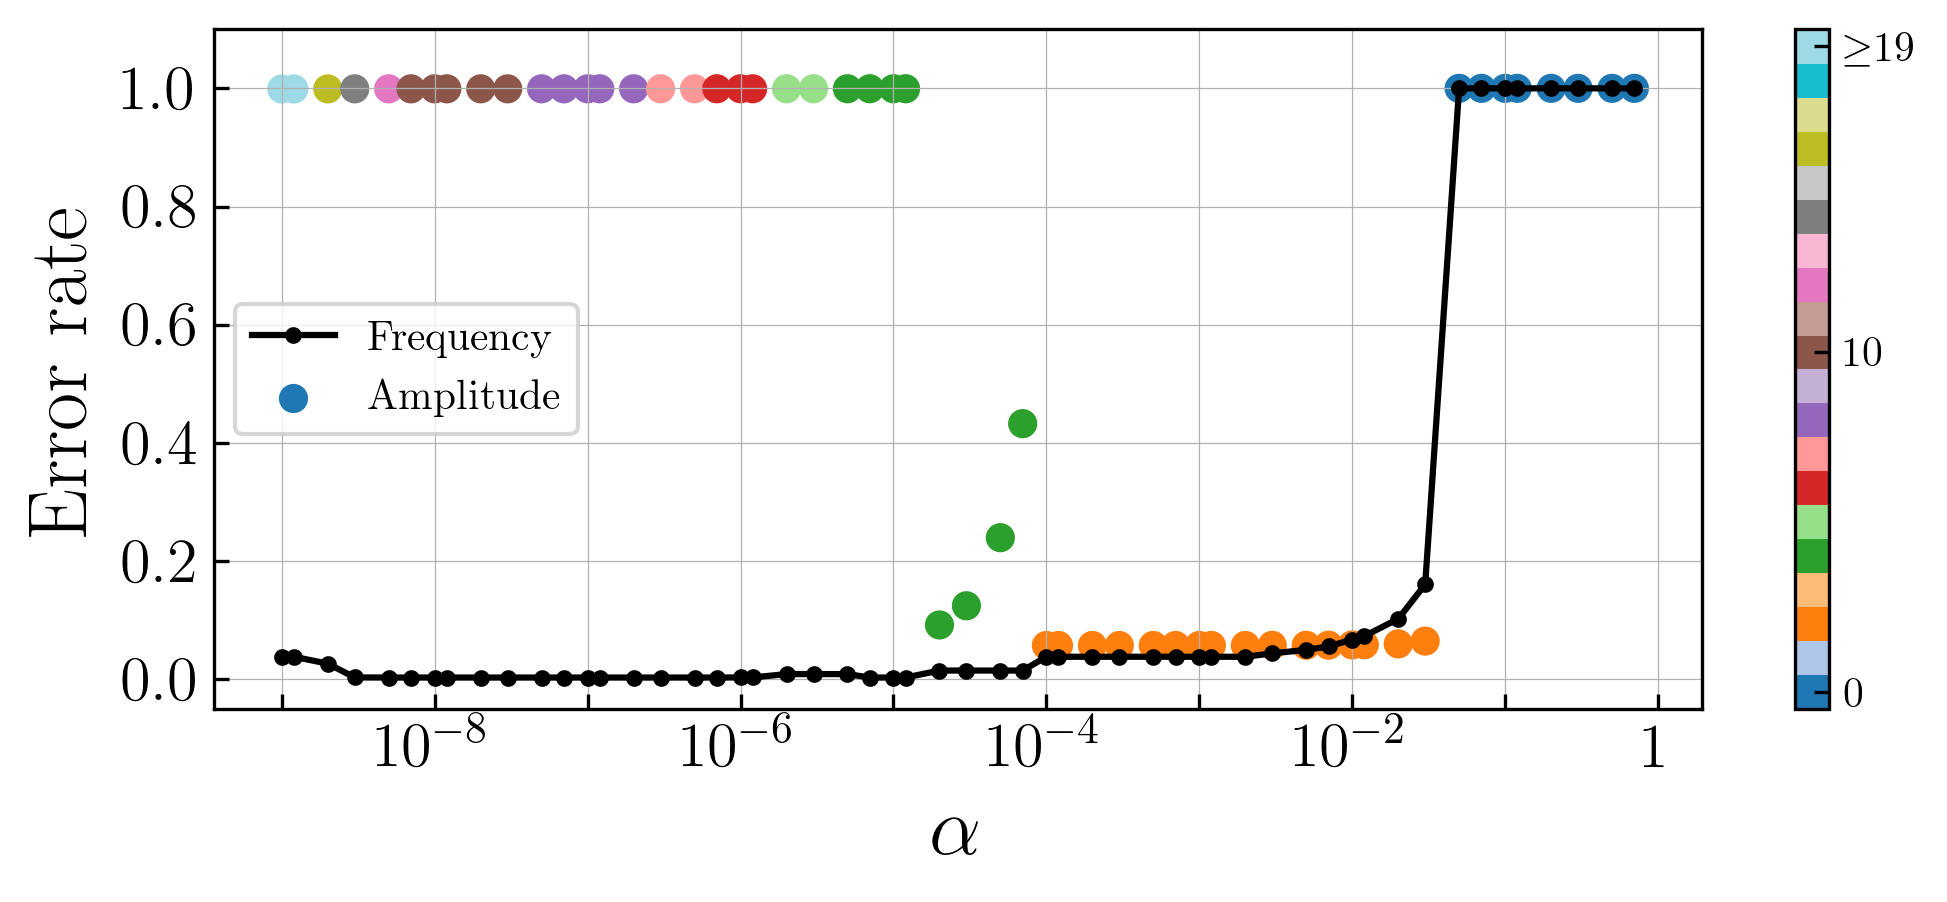

In [256]:
if len(alr)>1:
    print('2 Error rate')
    fonts1=20

    totalnum=nxcmp+nycmp
    totalnum[totalnum>20]=20
    plt.figure(dpi=300,figsize=(8,3))
    
    # https://codeday.me/jp/qa/20190104/119609.html
    noerror=np.isfinite(rms1)
    alr_ne=alr[noerror]
    err_rms=np.abs(rms1[noerror]-rmst)/rmst
    err_st=np.abs((starray[noerror]-0.1716)/0.1716)
    
    plt.scatter(alr_ne,err_rms,marker='o', c=totalnum[noerror], cmap='tab20', label='Amplitude'\
               ,vmin=-0.5, vmax=19.5)
#     plt.plot(alr, np.abs(rms1-rmst)/rmst, '.',label='RMS',c=tab20[])
    
    plt.plot(alr_ne, err_st, 'k.-',label='Frequency')
    plt.ylabel('Error rate', fontsize=fonts1)
    plt.xlabel(r'$\alpha$', fontsize=fonts1)
    plt.xscale('log')
    plt.xticks(ticks=[1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1],\
               labels=["","$10^{-8}$","","$10^{-6}$","","$10^{-4}$","","$10^{-2}$","","$1$"],\
               fontsize=fonts1-5)
    plt.yticks(fontsize=fonts1-5)
    plt.ylim([-0.05, 1.1])
    plt.grid(lw=0.3,which='both')
    plt.legend()
    cbar=plt.colorbar(ticks=[0.,10.,19.])
    cbar.ax.set_yticklabels(["0","10","$\geq$19"])
    plt.show()

Enlarged


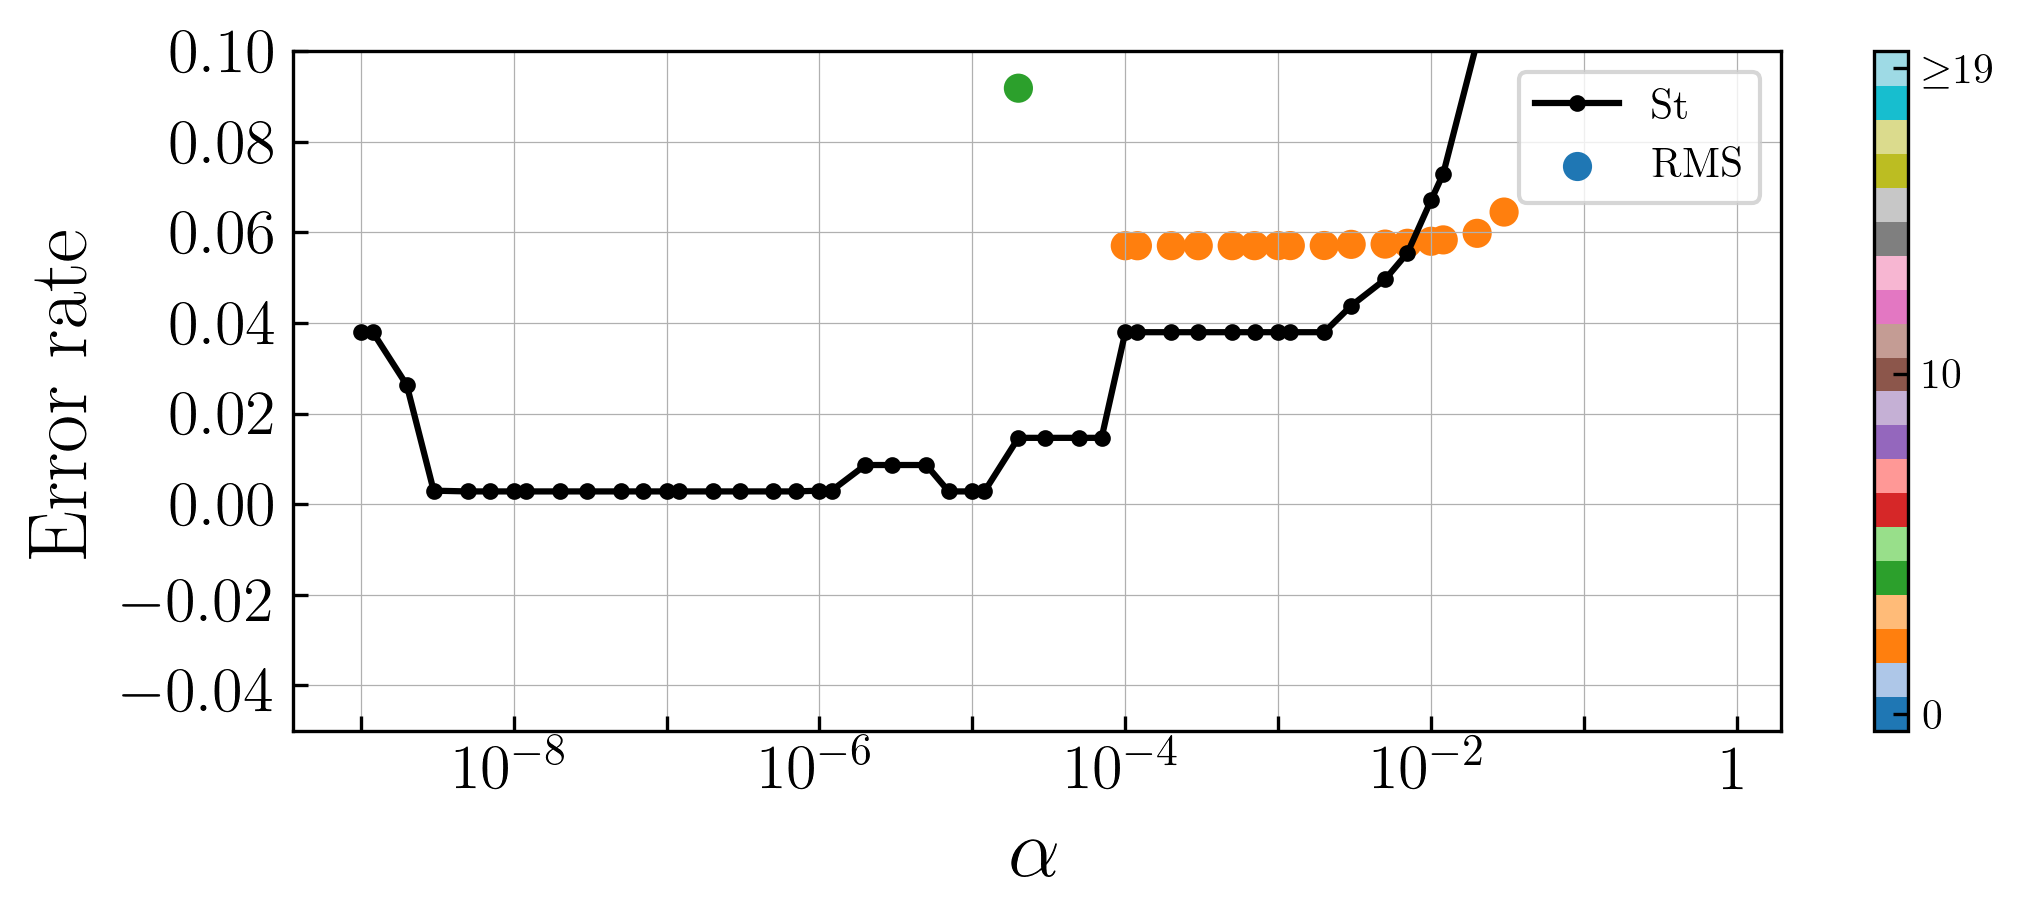

In [257]:
if len(alr)>1:
    print('Enlarged')
    fonts1=20

    totalnum=nxcmp+nycmp
    totalnum[totalnum>20]=20
    plt.figure(dpi=300,figsize=(8,3))
    
    # https://codeday.me/jp/qa/20190104/119609.html
    noerror=np.isfinite(rms1)
    alr_ne=alr[noerror]
    err_rms=np.abs(rms1[noerror]-rmst)/rmst
    err_st=np.abs((starray[noerror]-0.1716)/0.1716)
    
    plt.scatter(alr_ne,err_rms,marker='o', c=totalnum[noerror], cmap='tab20', label='RMS'\
               ,vmin=-0.5, vmax=19.5)
#     plt.plot(alr, np.abs(rms1-rmst)/rmst, '.',label='RMS',c=tab20[])
    
    plt.plot(alr_ne, err_st, 'k.-',label='St')
    plt.ylabel('Error rate', fontsize=fonts1)
    plt.xlabel(r'$\alpha$', fontsize=fonts1)
    plt.xscale('log')
    plt.xticks(ticks=[1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1],\
               labels=["","$10^{-8}$","","$10^{-6}$","","$10^{-4}$","","$10^{-2}$","","$1$"],\
               fontsize=fonts1-5)
    plt.yticks(fontsize=fonts1-5)
    plt.ylim([-0.05, 0.1])
    plt.grid(lw=0.3,which='both')
    plt.legend()
    cbar=plt.colorbar(ticks=[0.,10.,19.])
    cbar.ax.set_yticklabels(["0","10","$\geq$19"])
    plt.show()

# Perform SINDy at a certain ALPHA

In [258]:
# Set ALPHA <alr2> to reproduce flow field
alr2=np.array([1e-7]) # CNN5
alr2=np.array([1e-4]) # CNN1, CNN2, CNN3, CNN4
# alr2=np.array([2e-5])


# the integration time
stat=tax[0]
endt=10000
taxint=np.arange(dtsnap,endt,dtsnap)

In [259]:
## Fit
i=0
# Fit
# 0
xi1[:,0]=alasso(RHS0,LHS0,alr2[i])

# 1
xi1[:,1]=alasso(RHS1,LHS1,alr2[i])

xi=xi1.T

nxcmp[i]=np.count_nonzero(xi[0,:])
nycmp[i]=np.count_nonzero(xi[1,:])

def deriv2(t,y): 
    xxx=y[0]
    yyy=y[1]
    ii=0
    for i in range(n_order+1):
        for j in range(i+1):
            ii=ii+1
    rrhs=np.zeros([ii+usfl])+1
    ii=0
    for i in range(n_order+1):
        for j in range(i+1):
    #         print(ii)
            rrhs[ii]=xxx**(i-j)*yyy**j
            ii=ii+1
    if usesin:
        rrhs[ii+0]=np.sin(rrhs[1])
        rrhs[ii+1]=np.cos(rrhs[1])
        rrhs[ii+2]=np.sin(rrhs[2])
        rrhs[ii+3]=np.cos(rrhs[2])

    reconstx=np.dot(rrhs,xi.T)
#     print(rrhs)
    return ([reconstx[0], reconstx[1]])

v0=[data[0,0],data[0,1]]

vodeivp=solve_ivp(deriv2, [stat,endt], v0, method='RK45',t_eval=taxint)
#     print(vodeivp)
#     print(vodeivp.t.shape)
vodet=vodeivp.t
vodey=vodeivp.y

# NEW RMS
tempval=-100
intx1=vodey[0,:]
intx2=vodey[1,:]

meanx1=np.mean(intx1)
meanx2=np.mean(intx2)
mean1[i]=meanx1+meanx2

msx1=np.sum((intx1[tempval:]-meanx1)**2)
msx2=np.sum((intx2[tempval:]-meanx2)**2)

rmsx1=np.sqrt(msx1/tempval*-1)
rmsx2=np.sqrt(msx2/tempval*-1)
rms1[i]=rmsx1+rmsx2

stable_len=int((endt*0.8)/dtff)
if(len(intx1)>stable_len):
    tempval=-stable_len
    msx1=np.sum((intx1[tempval:]-meanx1)**2)
    msx2=np.sum((intx2[tempval:]-meanx2)**2)

    rmsx1=np.sqrt(msx1/tempval*-1)
    rmsx2=np.sqrt(msx2/tempval*-1)
    rms1[i]=rmsx1+rmsx2

# Calc. St
from scipy import signal
fft_target=signal.hann(len(vodey[0,:]))*vodey[0,:]
F=np.fft.fft(fft_target)
Amp=np.abs(F)
dt1=cp(dtff)
N1=len(vodey[1,:])

freq = np.linspace(0, 1.0/dtff, N1) 

starray[i]=freq[np.argmax(Amp[freq<0.3])]


# the part of calculating AIC
newy=np.zeros_like(data)
ii=0
for i2 in range(len(vodet)):
    if(ii<len(tax) and np.abs(tax[ii]-vodet[i2])<0.001):
        newy[ii,:]=vodey[:,i2]
        ii=ii+1
#     print(ii)
if(ii==len(tax)):
    rss=np.sum((data-newy)**2)
    aic1=len(tax)*np.log(rss/len(tax)) # likelihood
    aic2=(nxcmp[i]+nycmp[i])*2 # num of coefs.
    aic[i]=aic1+aic2
else:
    aic[i]=10**10


In [260]:
# Show eqs.
# n_order=5
# usesin=True

usfl=0
if usesin:
    usfl=4

ii=0
for i in range(n_order+1):
    for j in range(i+1):
        ii=ii+1
# odeterm=array([ii+usfl])+1
odeterm=[]
# print(odeterm.shape)
ii=0
for i in range(n_order+1):
    for j in range(i+1):
#         print(ii)
#         odeterm[ii]="x"*(i-j) #+ "y"*j
        odeterm.append("x"*(i-j) + "y"*j)
        ii=ii+1

if usesin:
    odeterm.append('sin(x)')
    odeterm.append('cos(x)')
    odeterm.append('sin(y)')
    odeterm.append('cos(y)')

# print(odeterm)

In [261]:
# Eq
non0=np.nonzero(xi)
odesindy2=[]
# odesindy2.append('')
# odesindy2.append('')
odesindy2.append('dx/dt=')
odesindy2.append('dy/dt=')
odesindy=[]
odesindy.append('')
odesindy.append('')
# ode[0]='dx/dt='
# ode[1]='dy/dt='
ii=0
non0t=non0[1][:]
# print(non0t)
for i in non0[0]:
    coefstr=xi[i,non0t[ii]]
    coefstr=format(coefstr,'+.2f')
#     print(coefstr)
    odesindy[i]=odesindy[i]+' '+coefstr+odeterm[non0t[ii]]
    ii=ii+1
    if(np.mod(ii,4)==0):
        odesindy[i]=odesindy[i]+'\n'
        
odesindy2[0]=odesindy2[0]+odesindy[0]
odesindy2[1]=odesindy2[1]+odesindy[1]
print('\n')
print(odesindy2[0])
print(odesindy2[1])
print('\n')



dx/dt= +1.02y
dy/dt= -1.06x




In [262]:
usfl=0
if usesin:
    usfl=4

ii=0
for i in range(n_order+1):
    for j in range(i+1):
        ii=ii+1
# odeterm=array([ii+usfl])+1
odeterm=[]
# print(odeterm.shape)
ii=0
for i in range(n_order+1):
    for j in range(i+1):
#         print(ii)
#         odeterm[ii]="x"*(i-j) #+ "y"*j
        ix=(i-j)
        iy=j
        str1=""
        if(ix>1): str1=str1+"x^{"+str(ix)+"}"
        if(ix==1): str1=str1+"x"
#         if(ix==0): odeterm.append("")
        
        if(iy>1): str1=str1+"y^{"+str(iy)+"}"
        if(iy==1): str1=str1+"y"
            
        odeterm.append(str1)
        ii=ii+1

if usesin:
    odeterm.append('sin(x)')
    odeterm.append('cos(x)')
    odeterm.append('sin(y)')
    odeterm.append('cos(y)')

# print(odeterm)

In [263]:
# For TEXCLIP
non0=np.nonzero(xi)
odesindy2=[]
# odesindy2.append('')
# odesindy2.append('')
odesindy2.append('\\frac{dx}{dt}&=')
odesindy2.append('\\frac{dy}{dt}&=')
odesindy=[]
odesindy.append('')
odesindy.append('')
# ode[0]='dx/dt='
# ode[1]='dy/dt='
ii=0
non0t=non0[1][:]
# print(non0t)
for i in non0[0]:
    coefstr=xi[i,non0t[ii]]
    coefstr=format(coefstr,'+.2f')
#     print(coefstr)
    odesindy[i]=odesindy[i]+' '+coefstr+odeterm[non0t[ii]]
    ii=ii+1
#     if(np.mod(ii,4)==0):
#         odesindy[i]=odesindy[i]+'\n'
        
odesindy2[0]=odesindy2[0]+odesindy[0]
odesindy2[1]=odesindy2[1]+odesindy[1]
print('\n')
print(odesindy2[0])
print(odesindy2[1])
print('\n')



\frac{dx}{dt}&= +1.02y
\frac{dy}{dt}&= -1.06x




## Plot

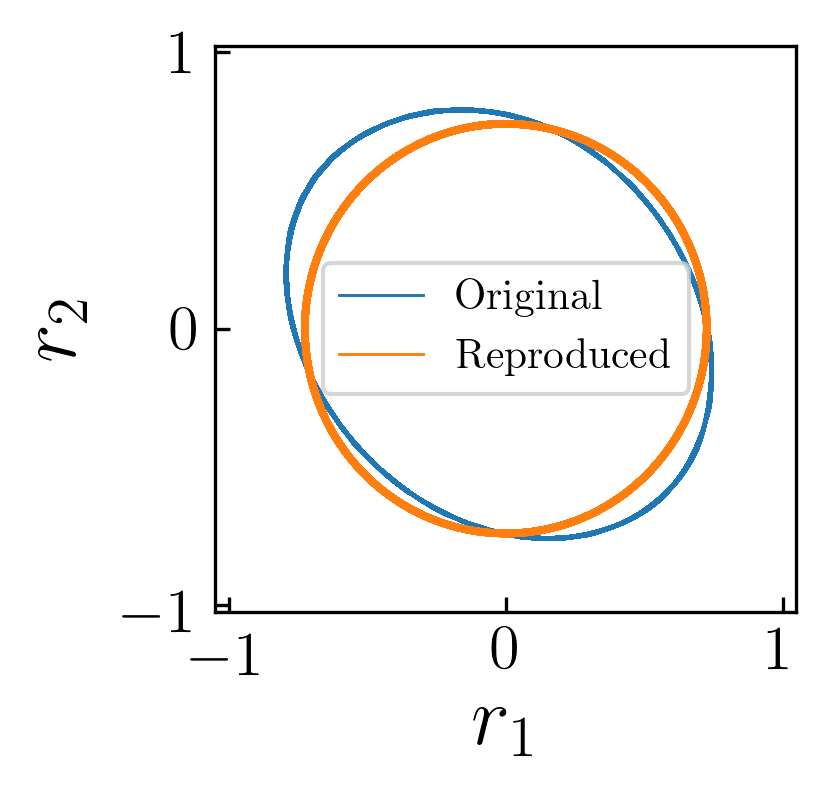

In [264]:
nlp=2000*100
plt.figure(dpi=300,figsize=(2.5,2.5))
plt.axis('equal')
plt.plot(data[:,0],data[:,1],lw=0.7,label='Original')
plt.plot(vodey[0,:nlp],vodey[1,:nlp],lw=0.7,label='Reproduced')
# plt.plot(tax,X[:,0,0,1],label='mode 2, [1,1]')
# plt.plot(tax,X[:,1,0,1],label='mode 2, [2,1]')
plt.xlabel(r"$r_1$",fontsize=20)
plt.ylabel(r"$r_2$",fontsize=20)
plt.xticks([-1,0,1],fontsize=15)
plt.yticks([-1,0,1],fontsize=15)
plt.xlim([-1.05,1.05])
plt.ylim([-1.05,1.05])
plt.legend()
plt.show()

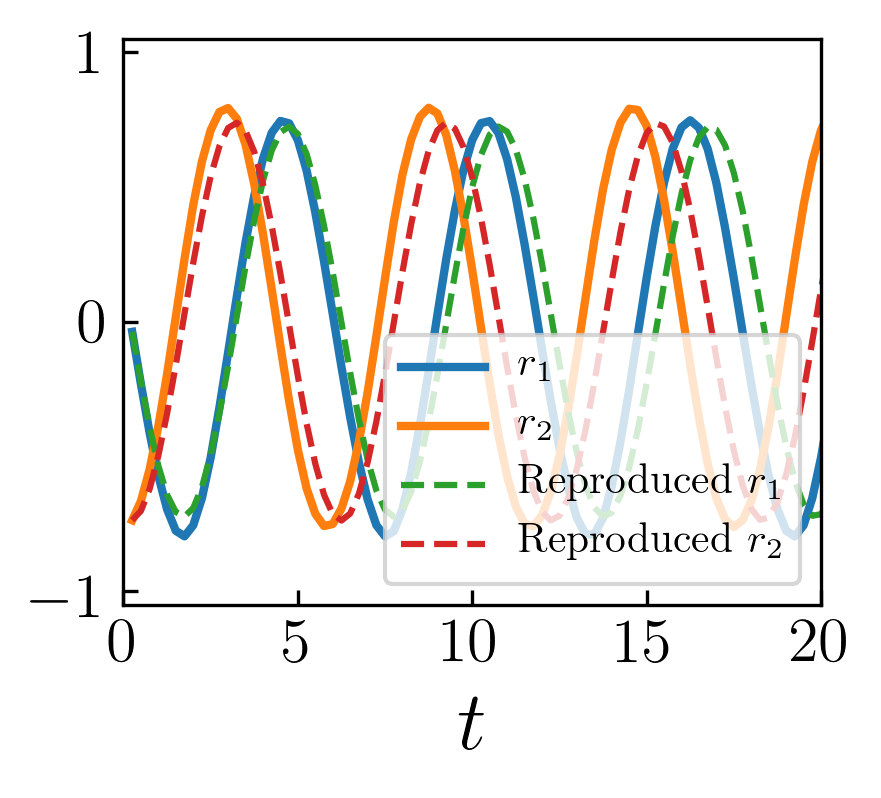

In [265]:
# Original and reproduced time history

# fig=plt.figure(dpi=300,figsize=(8,2))
fig=plt.figure(dpi=300,figsize=(3,2.5))
plt.plot(tax,data[:,0],lw=2,label=r'$r_1$')
plt.plot(tax,data[:,1],lw=2,label=r'$r_2$')
plt.plot(vodet,vodey[0,:],'--',label='Reproduced $r_1$')
plt.plot(vodet,vodey[1,:],'--',label='Reproduced $r_2$')

# plt.plot([1025,1025],[-2,2],'k',lw=0.5)
# plt.plot([1026,1026],[-2,2],'k',lw=0.5)
# plt.plot([1027,1027],[-2,2],'k',lw=0.5)
# plt.plot([1028,1028],[-2,2],'k',lw=0.5)
# plt.plot([1029,1029],[-2,2],'k',lw=0.5)

plt.xlim([0,50])
plt.xlim([0,20])
# plt.xlim([1020,1050])
# plt.xlim([800,900])

plt.legend(loc='lower right')
plt.xticks(fontsize=15)
plt.yticks([-1,0,1],fontsize=15)
plt.ylim([-1.05,1.05])
plt.xlabel(r'$t$',fontsize=20)
# plt.ylabel(r'Value',fontsize=20)
plt.show()

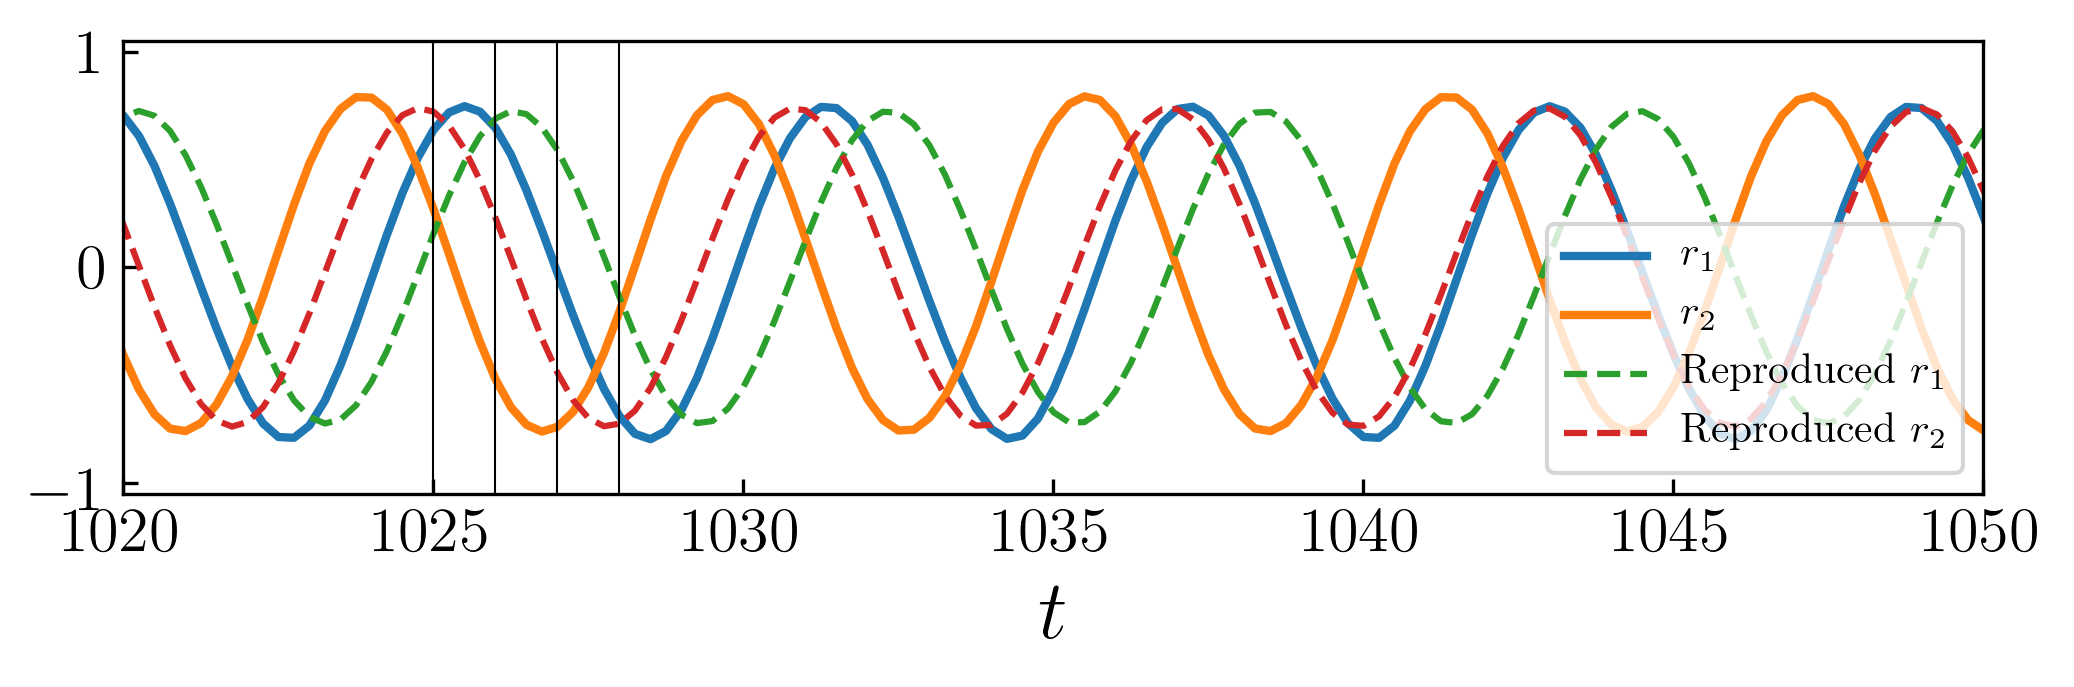

In [266]:
# Original and reproduced time history

fig=plt.figure(dpi=300,figsize=(8,2))
# fig=plt.figure(dpi=300,figsize=(3,2.5))
plt.plot(tax,data[:,0],lw=2,label=r'$r_1$')
plt.plot(tax,data[:,1],lw=2,label=r'$r_2$')
plt.plot(vodet,vodey[0,:],'--',label='Reproduced $r_1$')
plt.plot(vodet,vodey[1,:],'--',label='Reproduced $r_2$')

plt.plot([1025,1025],[-2,2],'k',lw=0.5)
plt.plot([1026,1026],[-2,2],'k',lw=0.5)
plt.plot([1027,1027],[-2,2],'k',lw=0.5)
plt.plot([1028,1028],[-2,2],'k',lw=0.5)
# plt.plot([1029,1029],[-2,2],'k',lw=0.5)

plt.xlim([0,50])
plt.xlim([0,20])
plt.xlim([1020,1050])
# plt.xlim([800,900])

plt.legend(loc='lower right')
plt.xticks(fontsize=15)
plt.yticks([-1,0,1],fontsize=15)
plt.ylim([-1.05,1.05])
plt.xlabel(r'$t$',fontsize=20)
# plt.ylabel(r'Value',fontsize=20)
plt.show()

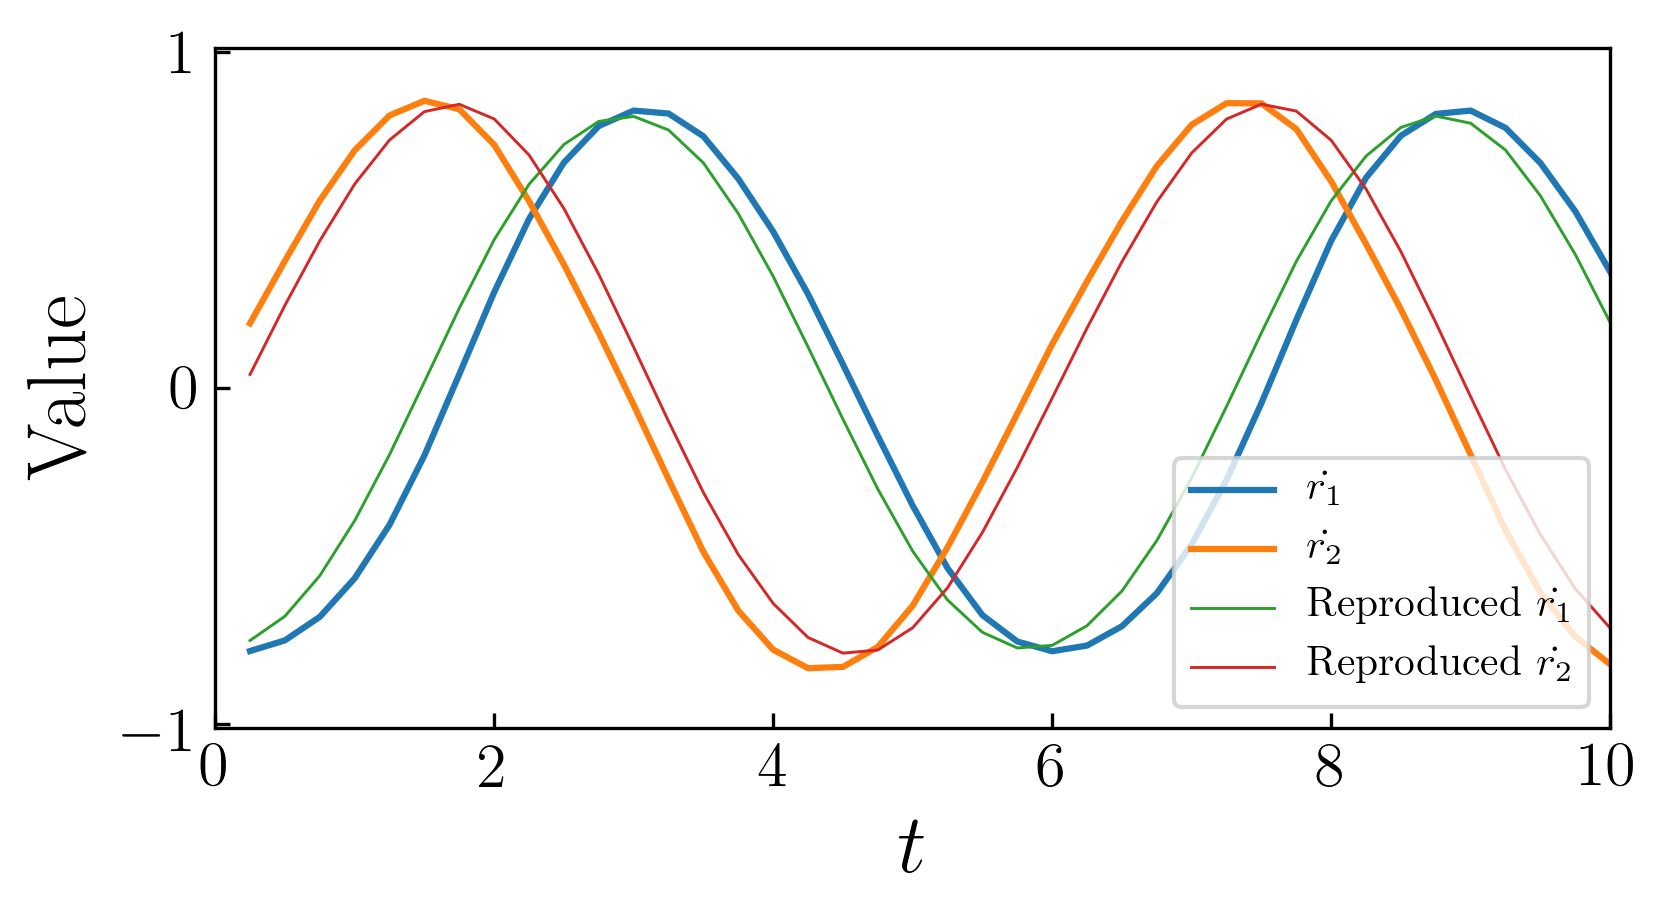

In [267]:
# Not shown in the Mthesis
rddata = np.zeros_like(ddata)
for i in range(len(ddata[:,0])):
    rddata[i,:]=np.array(deriv2(0,data[i,:]))

fig=plt.figure(dpi=300,figsize=(6,3))
plt.plot(tax,ddata[:,0],label=r'$\dot{r_1}$')
plt.plot(tax,ddata[:,1],label=r'$\dot{r_2}$')
plt.plot(tax,rddata[:,0],label=r'Reproduced $\dot{r_1}$',linewidth=0.7)
plt.plot(tax,rddata[:,1],label=r'Reproduced $\dot{r_2}$',linewidth=0.7)
plt.xlim([0,50])
plt.xlim([0,10])
plt.legend(loc='lower right')
plt.xticks(fontsize=15)
plt.yticks([-1,0,1],fontsize=15)
plt.ylim([-1.01,1.01])
plt.xlabel(r'$t$',fontsize=20)
plt.ylabel(r'Value',fontsize=20)
plt.show()

## Strouhal number

In [268]:
# St
# dtsnap=2.5e-3*100#*0.1
# n_ts=len(Xr[:,0,0,0])
# taxx2=np.arange(0,dtsnap*n_ts,dtsnap)

from scipy import signal
fft_target=signal.hann(len(vodey[0,:]))*vodey[0,:]
F=np.fft.fft(fft_target)
Amp=np.abs(F)

dt1=0.25
N1=len(vodey[0,:])

freq = np.linspace(0, 1.0/dt1, N1) 
# print(freq[signal.argrelmax(Amp, order=1)])
# print(freq[signal.argrelmax(Amp2, order=1)])

print('St:',freq[np.argmax(Amp[freq<0.3])])

# print(freq)

St: 0.16540827041352066


# Reproduced lat. -> Decoder

In [269]:
nlat=len(Xrall[:,0,0,0])
lat=vodey[:,:nlat]
taxdeco=vodet[:nlat]
print(lat.shape)

(2, 10000)


In [270]:
decof=decoder.predict(lat.T,verbose=1)
print(deco.shape)
deco=np.empty_like(decof)
deco[:,:,:,0]=decof[:,:,:,0]+Uf0
deco[:,:,:,1]=decof[:,:,:,1]+Vf0

10000/10000 [==============================] - 14s 1ms/step
(?, 384, 192, 2)


In [271]:
# (for comparison) CNN-AE
Xfall=np.empty_like(Xrall)

Xfall[:,:,:,0]=Xrall[:,:,:,0]-Uf0
Xfall[:,:,:,1]=Xrall[:,:,:,1]-Vf0

cnnaef=autoencoder.predict(Xfall,verbose=1)
cnnae=np.empty_like(cnnaef)
cnnae[:,:,:,0]=cnnaef[:,:,:,0]+Uf0
cnnae[:,:,:,1]=cnnaef[:,:,:,1]+Vf0

10000/10000 [==============================] - 44s 4ms/step


## Figure

In [272]:
# Define Plot
# Prepare circ
cx1=np.linspace(8.5,9.5,100)
cy1=np.sqrt(0.25-(cx1-9)**2)
cx2=np.linspace(9.5,8.5,100)
cy2=-np.sqrt(0.25-(cx1-9)**2)
circx=np.concatenate([cx1,cx2])
circy=np.concatenate([cy1,cy2])

import matplotlib.patches as patches

def contour(Uf,cmp,fs1,vm1,tcks):
    rUf=Uf
    if cmp==None:
        cmp='viridis'
    fig = plt.figure(dpi=300,figsize=(6,3))
    ax = plt.axes()
    plt.gca().set_aspect('equal') # axis equal
    plt.axis([8.2, 17.8, -2.4, 2.4])
    if vm1==None:
        plt.pcolor(xca,yca,rUf.T,cmap=cmp)#,vmin=-2,vmax=2)
    else:
        plt.pcolor(xca,yca,rUf.T,cmap=cmp,vmin=vm1[0],vmax=vm1[1])#,vmin=-2,vmax=2)
    plt.xticks(fontsize=fs1-5); plt.yticks(fontsize=fs1-5)
    plt.xticks([]); plt.yticks([])
    plt.plot(circx,circy,color='black',linewidth=1)
#     if tcks==None:
#         cb=plt.colorbar(shrink=0.8)
#     else:
#         cb=plt.colorbar(shrink=0.8,ticks=tcks)
#     for t in cb.ax.get_yticklabels():
#         t.set_fontsize(fs1-5)
#     plt.xlabel(r'$x$',fontsize=fs1)
#     plt.ylabel(r'$y$',fontsize=fs1)
    c = patches.Circle(xy=(9, 0), radius=0.5, fc='grey', ec='k')
    ax.add_patch(c)
    plt.show()
    return

- contour

1028.0 1028.0
U inp


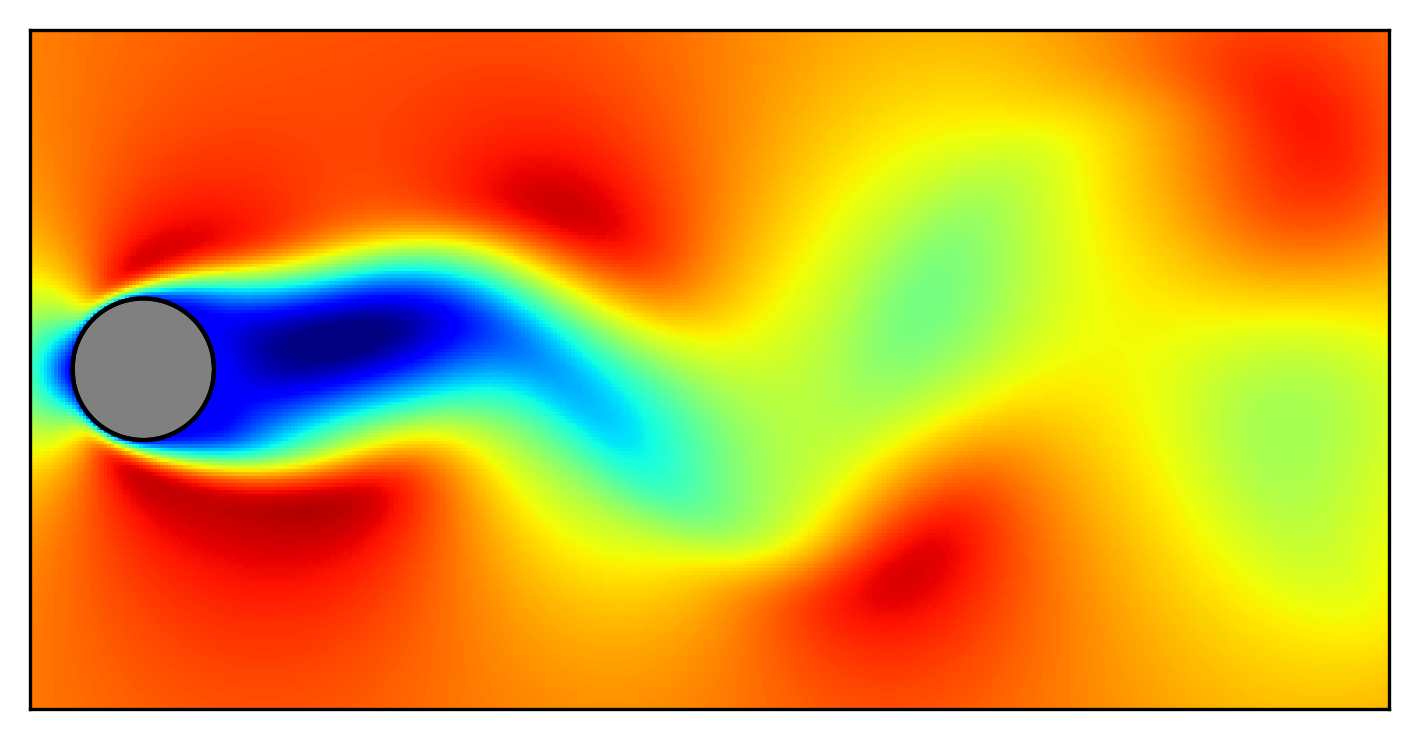

U SINDy


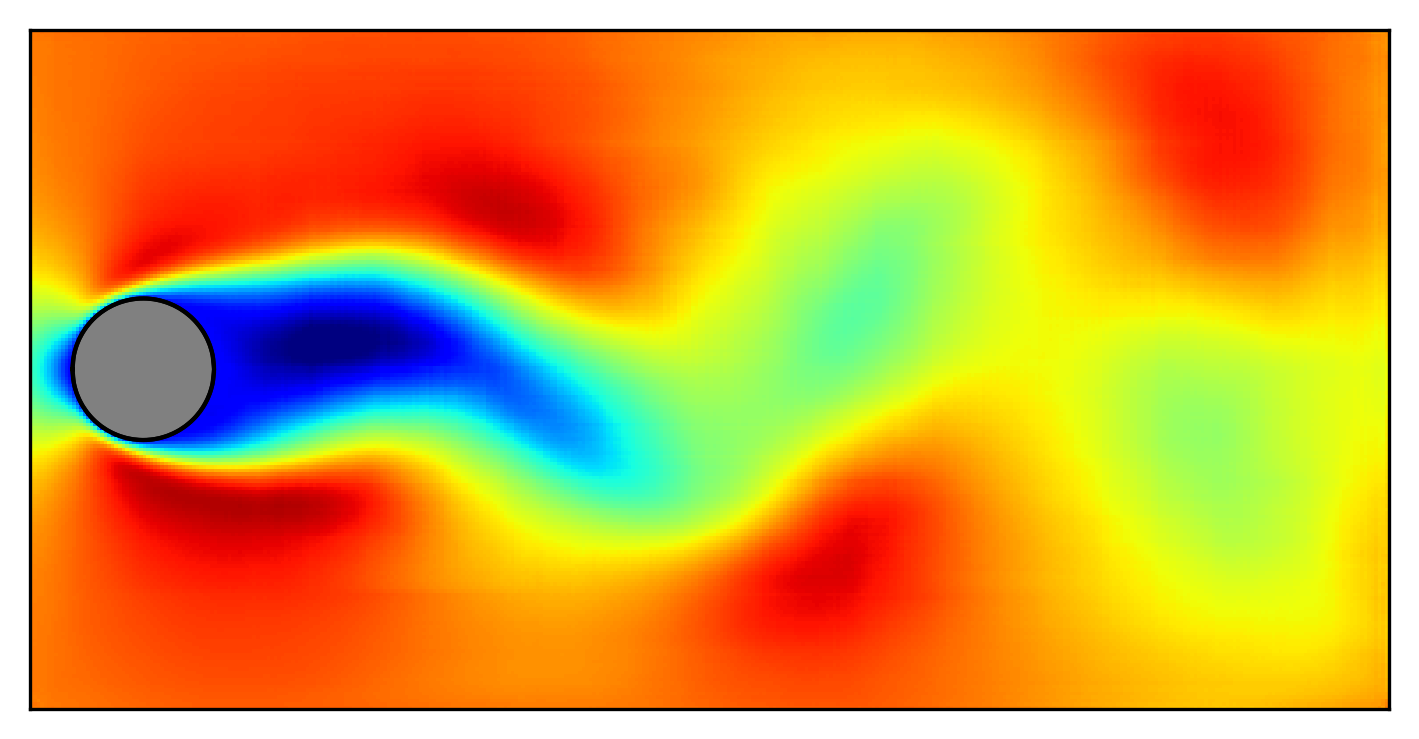

In [273]:
n=4008+4
# n=3996
n=4000-1+4*28
# print(n*dt1)
print(tax[n],vodet[n])

print('U inp')
contour(Xrall[n,:,:,0],'jet',30,[-0.2,1.4],None)
# print('U CNN')
# contour(cnnae[n,:,:,0],'jet',30,[-0.2,1.4],None)
print('U SINDy')
contour(deco[n,:,:,0],'jet',30,[-0.2,1.4],None)

V inp


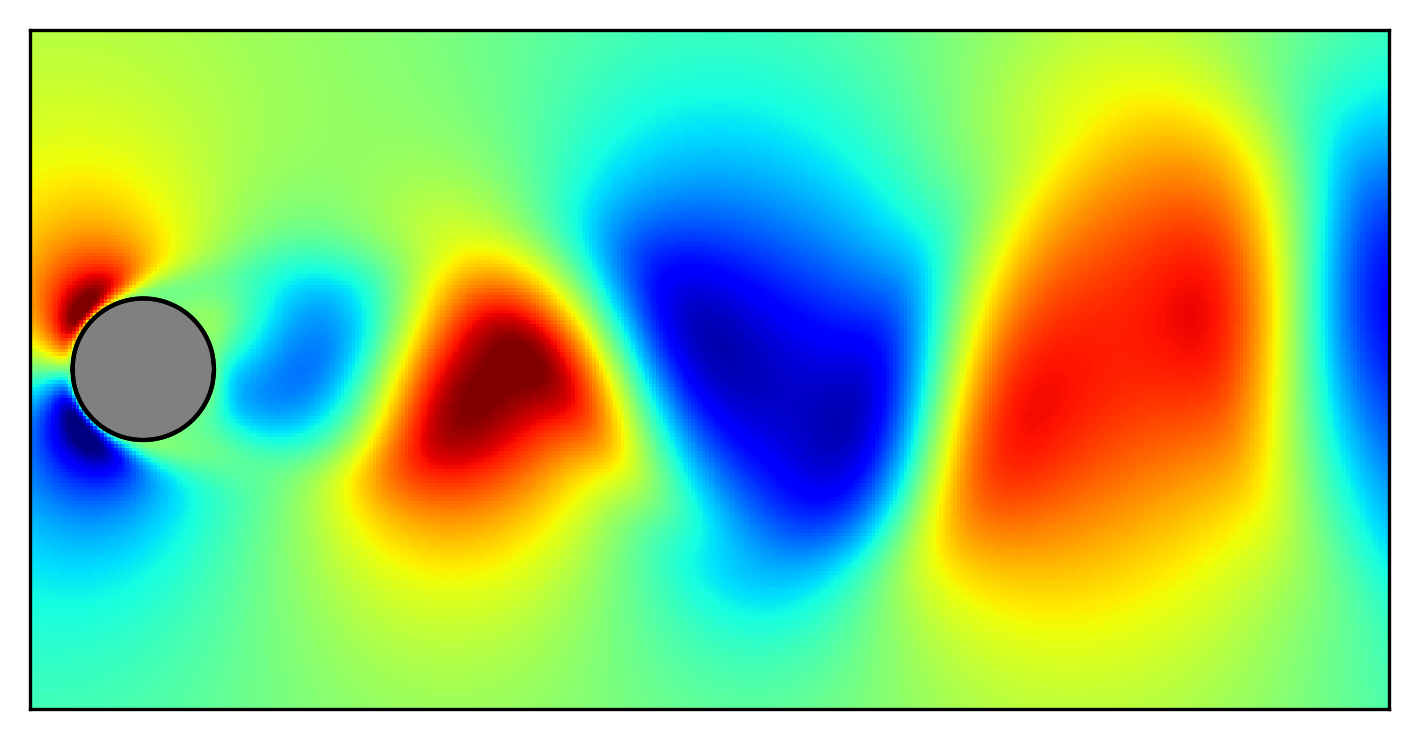

V SINDy


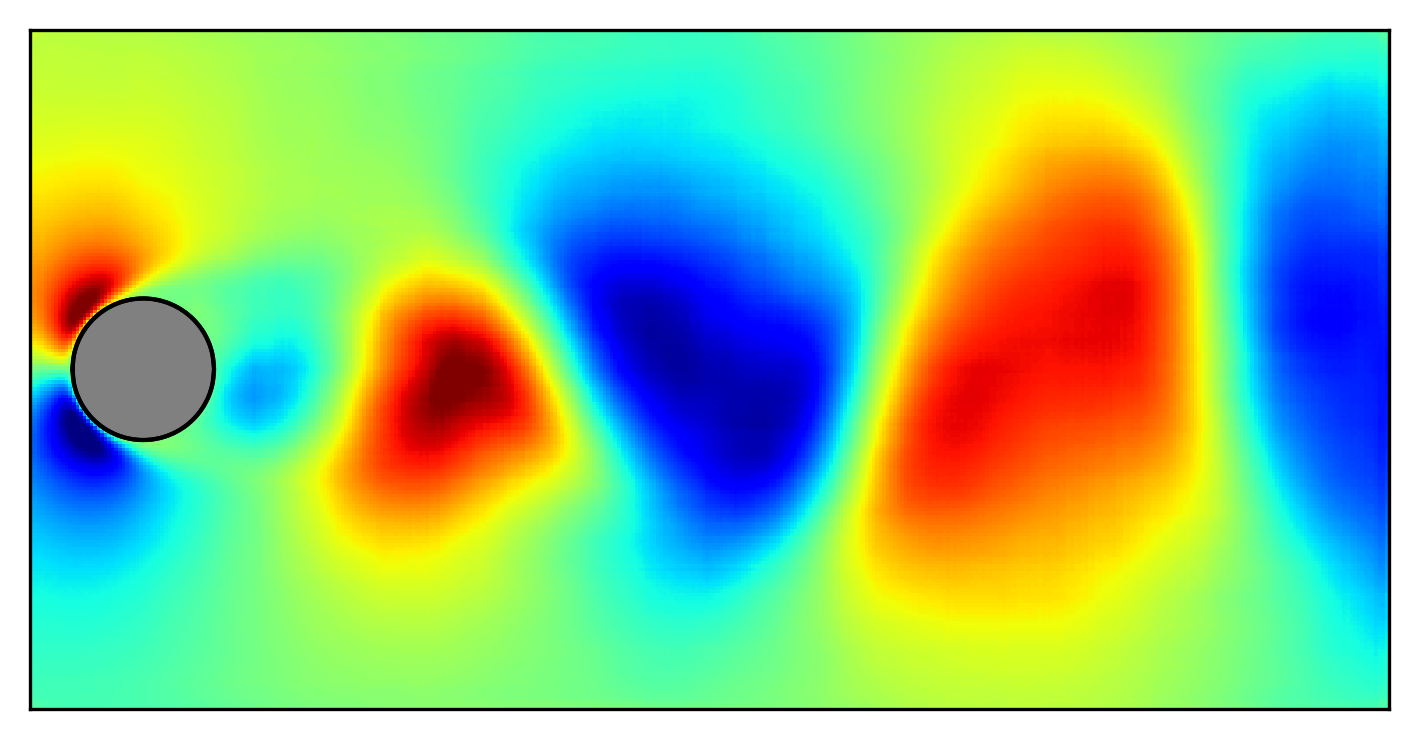

In [274]:
print('V inp')
contour(Xrall[n,:,:,1],'jet',30,[-0.6,0.6],None)
# print('U CNN')
# contour(cnnae[n,:,:,0],'jet',30,[-0.2,1.4],None)
print('V SINDy')
contour(deco[n,:,:,1],'jet',30,[-0.6,0.6],None)

- trajectory

In [275]:
dataall=encoder.predict(Xfall,verbose=1)

10000/10000 [==============================] - 35s 3ms/step


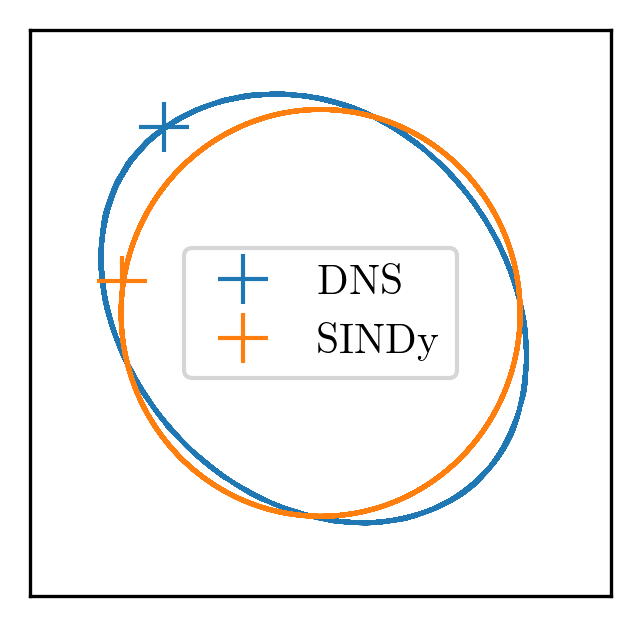

In [276]:
n00=0
dns1=4000+n00
sindy1=3996+n00

cmap = plt.get_cmap("tab10")
plt.figure(dpi=300,figsize=(2.5,2.5))
plt.axis('equal')
plt.plot(dataall[:dns1,0],dataall[:dns1,1],lw=0.7)#,label='Original')
plt.plot(dataall[dns1,0],dataall[dns1,1],'+',lw=0.7,label='DNS',color=cmap(0),markersize=12)
plt.plot(vodey[0,:sindy1],vodey[1,:sindy1],lw=0.7)#,label='Integration')
plt.plot(vodey[0,sindy1],vodey[1,sindy1],'+',lw=0.7,label='SINDy',color=cmap(1),markersize=12)
# plt.plot(tax,X[:,0,0,1],label='mode 2, [1,1]')
# plt.plot(tax,X[:,1,0,1],label='mode 2, [2,1]')
# plt.xlabel(r"$r_1$",fontsize=20)
# plt.ylabel(r"$r_2$",fontsize=20)
plt.xticks([])
plt.yticks([])
plt.xlim([-1.05,1.05])
plt.ylim([-1.05,1.05])
plt.legend()
plt.show()

## PDF

In [277]:
with open('/home/fukami/POD/POD2recX.pickle', 'rb') as f:
    POD2rec = pickle.load(f)
    
POD2rec=POD2rec.astype(np.float64) # flow field reconstructed by POD 2 modes

/home/fukami/anaconda3/envs/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


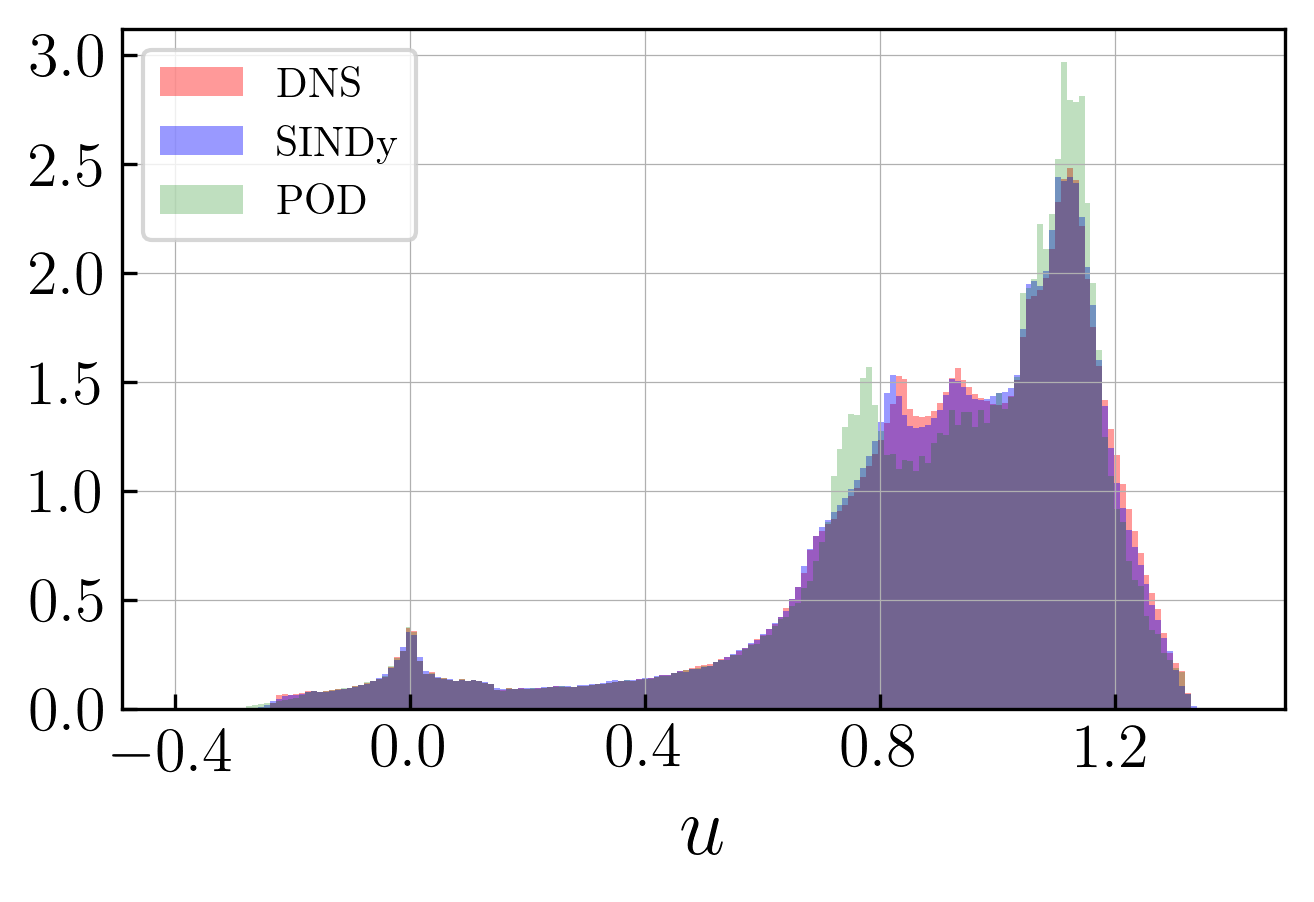

In [278]:
# U
uv=0
snapshots=2000
nmax=1.4
nmin=-0.4
binw=0.01

fig=plt.figure(dpi=300,figsize=(5,3))

plt.grid(lw=0.3)

plt.hist(np.ravel(Xr[0:snapshots,:,:,uv]),bins=int((nmax-nmin)/binw)
         , alpha=0.4, color='r',range=(nmin,nmax),normed=True,label='DNS')
plt.hist(np.ravel(deco[0:snapshots,:,:,uv]),bins=int((nmax-nmin)/binw)
         , alpha=0.4, color='b',range=(nmin,nmax),normed=True,label='SINDy')
plt.hist(np.ravel(POD2rec[0:snapshots,:,:,uv]),bins=int((nmax-nmin)/binw)
         , alpha=0.25, color='g',range=(nmin,nmax),normed=True,label='POD')

plt.xlabel("$u$",fontsize=20)
# plt.ylabel("Frequency",fontsize=20)
plt.xticks([-0.4,0,0.4,0.8,1.2],fontsize=15)
plt.yticks(fontsize=15)
plt.legend()
plt.show()

/home/fukami/anaconda3/envs/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


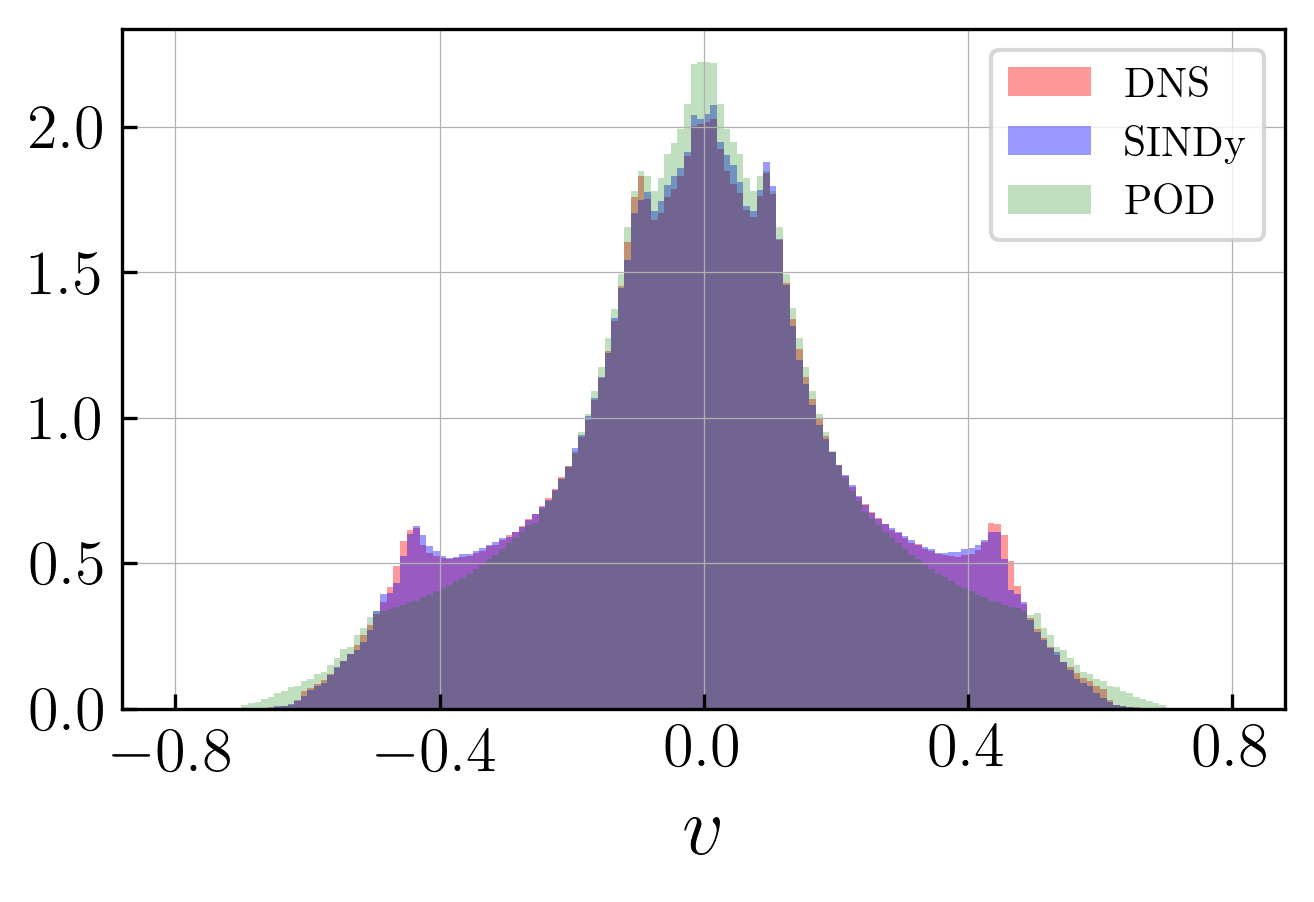

In [51]:
# V
uv=1
nmax=0.8
nmin=-0.8

fig=plt.figure(dpi=300,figsize=(5,3))

plt.grid(lw=0.3)

plt.hist(np.ravel(Xr[0:snapshots,:,:,uv]),bins=int((nmax-nmin)/binw)
         , alpha=0.4, color='r',range=(nmin,nmax),normed=True,label='DNS')
plt.hist(np.ravel(deco[0:snapshots,:,:,uv]),bins=int((nmax-nmin)/binw)
         , alpha=0.4, color='b',range=(nmin,nmax),normed=True,label='SINDy')
plt.hist(np.ravel(POD2rec[0:snapshots,:,:,uv]),bins=int((nmax-nmin)/binw)
         , alpha=0.25, color='g',range=(nmin,nmax),normed=True,label='POD')

plt.xlabel("$v$",fontsize=20)
# plt.ylabel("Frequency",fontsize=20)
plt.xticks([-0.8,-0.4,0,0.4,0.8],fontsize=15)
plt.yticks(fontsize=15)
plt.legend()
plt.show()